In [1]:
import datetime
import gc
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import lightgbm as lgb

import shap
shap.initjs()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'svg' 

from preprocessing import load_messages, translit

### Загузка и предварительная очитка данных 
Для исследования мы испоьзовали сведий дамп слака ODS от 06 марта 2021 года.<br>
Каналы jobs и jobs hr. Загрузим сообщения в pandas df и очистим от лишний информации.

In [2]:
messages = load_messages('jobs', 'jobs_hr')


Загружено 47767 cообщений
	Удалены технические сообщения: 6864 сообщений
	Дата и время округлены до секунд и переведены в datetime формат
	Текст приведен к маленьким буквам и очищен от лишних пробелов
Осталось 40903 cообщений


### Кол-во сообщений

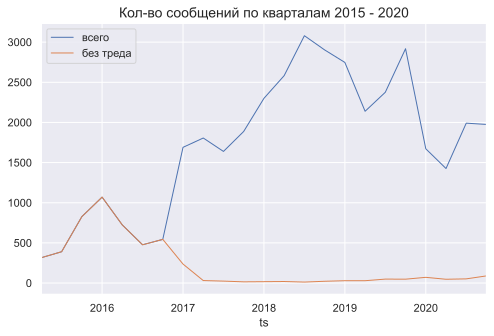

In [3]:
plt.figure(figsize = (8, 5))
messages[messages.ts.dt.year < 2021].resample('Q', on = 'ts')['ts'].count().plot(linewidth=1,
                                                                                 label='всего')
messages[(messages.thread_ts.isna()) & 
         (messages.ts.dt.year < 2021)].resample('Q', on = 'ts')['ts'].count().plot(linewidth=1,
                                                                                   label='без треда')
plt.legend()
plt.title('Кол-во сообщений по кварталам 2015 - 2020', size=14)
plt.show()

Общее кол-во сообщений достигло <b>максимума в 3 квартале 2018 года</b>.<br>
После этого активность снижалась - резкое <b>падение активности произошло в 2020 году</b>

#### Что это кронокризис или хайп по data science уже прошел?

Здесь мы смотрим на все сообщения - это и сами вакансии и комментарии пользователей.<br>
До 2017 года тредов вообще не было и все сообщения сыпались в общий канал.<br>
У части сообщений и сейчас нет треда - если никто не оставил комментарий.<br>

Для дальнейшего анализа нам нужно отделать сообщения с вакансиями от комментариев пользователей.<br>
Самый простой подход - это считать вакансией все сообщения с котрых начинается тред (thread_ts = ts).<br>
Но тогда мы потеряем всю статистику за 2015-2016 года.<p>
    
Второй вариант - это обучить простую модель на этой метке и разделить с ее помошбю сообщения без треда.<br>

### Классификация сообщений на вакансии и комментарии

В качесстве признаков будет использовать count по всем словам в сообщении.

In [4]:
# CountVectorizer для текста
countvectorizer = CountVectorizer(ngram_range=(1, 2), max_features=2000)
countvectorizer.fit(messages['text'])
word_cols = countvectorizer.get_feature_names()
word_cols = ['_' + translit(col) + f'_{i}' for i, col in enumerate(word_cols)]

# Добавлеям колонки с count по словам
messages = pd.concat((messages, pd.DataFrame(countvectorizer.transform(messages['text']).toarray(), 
                                 columns=word_cols)), axis=1)

# Делим на трейн и тест и обучаем модель
df = messages[~messages['thread_ts'].isna()].reset_index(drop=True)
df['is_job'] = (df['thread_ts'] == df['ts']).astype('int8')
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, word_cols], df['is_job'],
                                                    test_size = 0.33, random_state = 555)
gbm1 = lgb.LGBMClassifier(num_leaves=7, n_estimators=200, feature_fraction=0.3, bagging_fraction=0.5)
gbm1.fit(X_train, y_train)

# Помечяем вакансии новой моделью
messages['is_job'] = gbm1.predict(messages.loc[:, word_cols])
messages = messages.loc[:,[i for i in messages.columns if i not in word_cols]]

del X_train, y_train, df
gc.collect()

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3


3914

#### Качество модели
<p>Качества этой простой модели более чем достаточно для поставленной задачи.<br>
Тем более, что разметка для обучения шумная и не на 100% точная.<p>

In [5]:
# Считаем метрики
accuracy_baseline = round(sum(y_test == 0) / len(y_test) * 100, 1)
print(f'Accuracy для наивной модели {accuracy_baseline}')
pred = gbm1.predict(X_test)
accuracy_model = round(sum(y_test == pred) / len(y_test) * 100, 1)
print(f'Accuracy для модели {accuracy_model}')
print(f'F1 score {f1_score(y_test, pred)}')

Accuracy для наивной модели 93.4
Accuracy для модели 99.6
F1 score 0.9666884389288046


#### Важность признаков
Вакансии и комментарии легко сплитятся по используемым словам.
Например на вакансию указывают такие слова: 
<li> навыки: python, sql, data, английский
<li> ссылки и email: http, https, mailto
<li> слова связанные с вилкой зп: вилка, от, fork, 200, 50 и т.д.
<li> другие слова часто встречаемые в описании вакансий: опыт, привет (в комментах люди редко здороваются), на, ищем, офис, москва, требования<p>
    
На комментарий указывают разговорные слова характерные для ответов:<br>
вот, просто, так, уже, есть, gt (использование цитаты)<p>

Ниже можно посомотреть top50 признаков из модели по версии shap

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


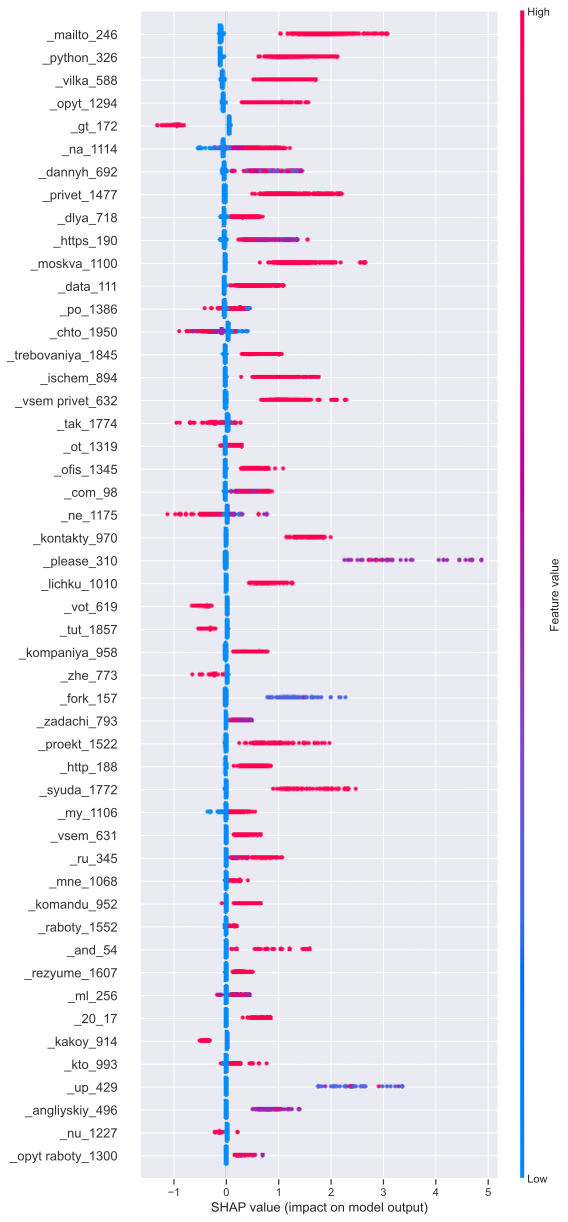

In [6]:
# Нарисуем шап для модели
explainer = shap.TreeExplainer(gbm1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test, max_display=50)

### Кол-во сообщений с вакансиями

Теперь, с помощью нашей модели можно выделить только ваканси и посмотреть на их динамику<br>
Паника отменяется, товарищи, <b>кол-во вакнсий по прежнему растет!</b><br>
К концу 2020 года - было чуть меньше 100 вкансий в месяц, а за февраль 2021 уже почти 140!

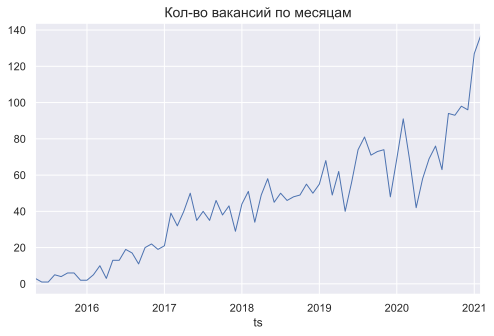

In [7]:
plt.figure(figsize = (8, 5))
messages[(messages.is_job==1) & 
         (messages.ts < '2021-03-01')].resample('M', on = 'ts')['ts'].count().plot(linewidth=1)
plt.title('Кол-во вакансий по месяцам', size=14)
plt.show()

### В какой месяц искать работу?

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
month = messages[(messages.is_job == 1) &
                 (messages.ts.dt.year > 2015) &
                 (messages.ts.dt.year < 2021)].resample('M', on = 'ts').agg({'ts': 'count'})  
month.columns = ['count']
month['month'] = month.index.month
month['order'] = [*range(1, len(month)+1)]
month = pd.concat([month, pd.get_dummies(month.month)], axis=1)
reg = LinearRegression()
cols =  [i for i in month.columns if i not in ['count', 'month']]
reg.fit(month.loc[:, cols], month['count'])
month['pred'] = reg.predict(month.loc[:, cols])

<AxesSubplot:xlabel='ts'>

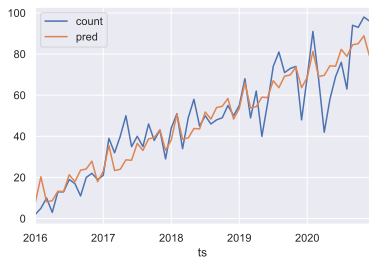

In [10]:
month.loc[:,['count', 'pred']].plot()

### Вспомогательные функции

In [33]:
# конвертация строки dataframe в dict

def convert_row_to_dict(row, columns):
    count = 1
    dictionary = {}
    dictionary['Index'] = row[0]
    for column in columns:
        dictionary[column] = row[count]
        count += 1
    return dictionary


# красиво вывести словарь

def print_dict(dictionary):
    for key, value in dictionary.items():
        print(key, ':', value)

# сортировка словаря по значениям ключей

def sort_dict_by_values(dictionary, reverse=True):
    return {key: value for key, value in sorted(dictionary.items(), reverse=reverse, key=lambda item: item[1])}

### Какие технологии используются

In [12]:
import matplotlib.pyplot as plt
from collections import defaultdict

In [13]:
def build_histogram_by_keywords(texts, dictionary, dictionary_mapping, color='gold'):
    for text in texts:
        for key in dictionary.keys():
            key_variations = dictionary_mapping[key]
            for key_variation in key_variations:
                if key_variation in text.lower():
                    dictionary[key] += 1
                    break
                    
    sorted_dictionary = {key: value for key, value in sorted(dictionary.items(), reverse=True, key=lambda item: item[1])}
    print(sorted_dictionary)
    
    plt.figure(figsize=(3 + len(dictionary.keys()), 5))
    plt.bar(sorted_dictionary.keys(), sorted_dictionary.values(), color=color)
    plt.show()

In [74]:
def get_found_words_in_text(text, dictionary_mapping):
    found_words = {
        key: False for key in dictionary_mapping.keys()
    }
    at_least_one_word_found = False
    ds_word_found = False
    for key, key_variations in dictionary_mapping.items():
        for key_variation in key_variations:
            if key_variation in text.lower():
                found_words[key] = True
                at_least_one_word_found = True
                if key == 'Data Scientist':
                    ds_word_found = True
                break
    return found_words, at_least_one_word_found, ds_word_found


def get_technologies_distribution_and_years(messages, dictionary_mapping, years, ds_jobs_mapping=None):
    dictionary = {
        key: {
            year: 0 for year in years
        } for key in dictionary_mapping.keys()
    }
    dictionary['Else'] = {
        year: 0 for year in years
    }
    
    if ds_jobs_mapping is not None:
        ds_dictionary = {
            key: {
                year: 0 for year in years
            } for key in ds_jobs_mapping.keys()
        }
        ds_dictionary['Else'] = {
            year: 0 for year in years
        }
    
    for row in messages.itertuples():
        row_dict = convert_row_to_dict(row, messages.columns)
        year = row_dict['ts'].year
        if year not in years:
            continue
        technologies, at_least_one_word_found, ds_word_found = get_found_words_in_text(row_dict['text'], dictionary_mapping)
        if not at_least_one_word_found:
            dictionary['Else'][year] += 1
        for key, value in technologies.items():
            if value:
                dictionary[key][year] += 1
                
        if ds_jobs_mapping is not None and ds_word_found:
            technologies, at_least_one_word_found, ds_word_found = get_found_words_in_text(row_dict['text'], ds_jobs_mapping)
            if not at_least_one_word_found:
                ds_dictionary['Else'][year] += 1
            for key, value in technologies.items():
                if value:
                    ds_dictionary[key][year] += 1
    
    if ds_jobs_mapping is None:
        return dictionary
    else:
        return dictionary, ds_dictionary


def build_hist_from_distribution(distribution, years, title='', xlabel='', ylabel=''):
    colors=['gold', 'deepskyblue', 'greenyellow', 'orangered', 'blueviolet', 'lightgray']
    n = len(distribution.keys())
    i = 0
    coef = 0.8
    width = coef / n
    plt.figure(figsize=(2 * n, 7))
    for key, technology in distribution.items():
        color = 'lightgray' if key == 'else' else colors[i]
        plt.bar(np.array(years) + width * (i + 0.5 * (1 - n)), technology.values(),
                label=key, width=width, color=color)
        i += 1
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

### Добавление новых признаков к датасету

In [79]:
# добавление года

def add_year_column(messages):
    years = []
    for row in messages.itertuples():
        row_dict = convert_row_to_dict(row, messages.columns)
        year = row_dict['ts'].year
        years.append(year)
    messages['year'] = years
    
    
add_year_column(messages)

,ts,user,text,user_profile,attachments,edited,reactions,thread_ts,reply_count,reply_users_count,...,pytorch,tensorflow,keras,data_scientist,data_engineer,data_analyst,computer_vision,deep_learning,nlp,year
0,2016-07-22 15:11:48,U0441TBSV,"ребят, привет! заранее извиняюсь, если пишу не...","{'avatar_hash': '4bc716f1e7d4', 'image_72': 'h...",NaN,NaN,"[{'name': '+1', 'users': ['U0G29N5U4', 'U041LH...",NaT,NaN,NaN,...,False,False,False,False,False,False,False,False,False,2016
1,2016-07-22 17:49:23,U0ZHCGY5T,<@u0441tbsv> мини-уточняющий вопрос:\nнужны ...,"{'avatar_hash': 'a495ad6bdbb8', 'image_72': 'h...",NaN,NaN,NaN,NaT,NaN,NaN,...,False,False,False,False,False,False,False,False,False,2016
2,2019-11-21 11:08:43,U7CAU0GMU,"&gt; даже если не получится, мы дадим обратную...","{'avatar_hash': '69c0136d324c', 'image_72': 'h...",NaN,NaN,"[{'name': 'true-story', 'users': ['UDSC91AH1',...",2019-11-21 08:28:31,NaN,NaN,...,False,False,False,False,False,False,False,False,False,2019
3,2019-11-21 11:19:13,U6X06R596,привет!\n*позиция:* team lead (data science)\n...,"{'avatar_hash': '82d5656665ba', 'image_72': 'h...",NaN,"{'user': 'U6X06R596', 'ts': '1574325820.000000'}","[{'name': 'notbad_n01z3', 'users': ['UAF1W2R3M...",2019-11-21 11:19:13,3.0,3.0,...,True,True,False,True,False,False,True,True,True,2019
4,2019-11-21 11:26:46,UDSBE0FKN,потому что отказ формулировал :robot_face:,"{'avatar_hash': 'f36767011b7c', 'image_72': 'h...",NaN,NaN,"[{'name': 'trollface', 'users': ['U7CAU0GMU', ...",2019-11-21 08:28:31,NaN,NaN,...,False,False,False,False,False,False,False,False,False,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40898,2020-01-22 09:24:05,USDKE79NF,"<@ufs53l1fv>, 16 чел.","{'avatar_hash': 'e0e83ee0ec15', 'image_72': 'h...",NaN,NaN,NaN,2020-01-21 17:46:28,NaN,NaN,...,False,False,False,False,False,False,False,False,False,2020
40899,2020-01-22 09:27:23,USDKE79NF,команда - огонь! ребята из топовых международн...,"{'avatar_hash': 'e0e83ee0ec15', 'image_72': 'h...",NaN,NaN,"[{'name': 'heavy_plus_sign', 'users': ['U5EF4E...",2020-01-21 17:46:28,NaN,NaN,...,False,False,False,False,False,False,False,False,False,2020
40900,2019-12-09 00:23:17,U6GHF30CV,что останется после налогов? можете вилку в не...,"{'avatar_hash': 'f98f372ced13', 'image_72': 'h...",NaN,NaN,NaN,2019-12-06 21:19:15,NaN,NaN,...,False,False,False,False,False,False,False,False,False,2019
40901,2020-05-23 19:41:50,U64GCA997,"забавно, что если вместо названия написано nda...","{'avatar_hash': '2dd94c6164f7', 'image_72': 'h...",NaN,"{'user': 'U64GCA997', 'ts': '1590252146.000000'}",NaN,2020-04-06 17:03:35,NaN,NaN,...,False,False,False,False,False,False,False,False,False,2020


In [51]:
import re

def add_feature(messages, feature_name, feature_regexs):
    labels = []
    for row in messages.itertuples():
        row_dict = convert_row_to_dict(row, messages.columns)
        text = row_dict['text']
        regex_found = False
        for feature_regex in feature_regexs:
            if re.search(r'{}'.format(feature_regex), text):
                regex_found = True
                break
        labels.append(regex_found)
    messages[feature_name] = labels

In [65]:
levels_dict = {
    'intern': ['intern', 'стажер', 'стажёр'],
    'junior': ['junior', 'джун', 'начинающ'],
    'middle': ['middle', 'мидл', 'миддл'],
    'senior': ['senior', 'синьор', 'сеньор', 'старш'],
    'lead': ['lead', 'head', 'лид', 'ведущ']
}

dl_frameworks_dict = {
    'pytorch': ['pytorch'],
    'tensorflow': ['tensorflow', 'tf'],
    'keras': ['keras']
}

jobs_dict = {
    'data_scientist': [' ds ', 'data science', 'data scientist', 'дата саенс', 'дата саентист'],
    'data_engineer': [' de ', 'data engineer', 'дата инженер'],
    'data_analyst': [' da ', 'data analyst', 'data analytic', 'аналитик']
}

ds_jobs_dict = {
    'computer_vision': [' cv ', 'computer vision', 'компьютерное зрение', 'компьютерным зрением'],
    'deep_learning': [' dl ', 'deep learning', 'глубокое обучение', 'глубоким обучением', 'глубокого обучения'],
    'nlp': [' nlp ', 'natural language processing', 'обработка естественного языка', 'обработкой естественного языка']
}

dicts = [levels_dict, dl_frameworks_dict, jobs_dict, ds_jobs_dict]
for dict_ in dicts:
    for feature_name, feature_regexs in dict_.items():
        add_feature(messages, feature_name, feature_regexs)

In [71]:
def get_distribution_by_years(messages, features, years):
    distribution = {
        feature: {
            year: 0 for year in years
        } for feature in features
    }
    distribution['else'] = {
        year: 0 for year in years
    }
    for row in messages.itertuples():
        row_dict = convert_row_to_dict(row, messages.columns)
        year = row_dict['ts'].year
        if year not in years:
            continue
        feature_was_found = False
        for feature in features:
            if row_dict[feature]:
                distribution[feature][year] += 1
                feature_was_found = True
        if not feature_was_found:
            distribution['else'][year] += 1
    return distribution


def convert_distribution_to_df(distribution):
    pass

In [ ]:
years = range(2016, 2022)

### Анализ различных фреймворков

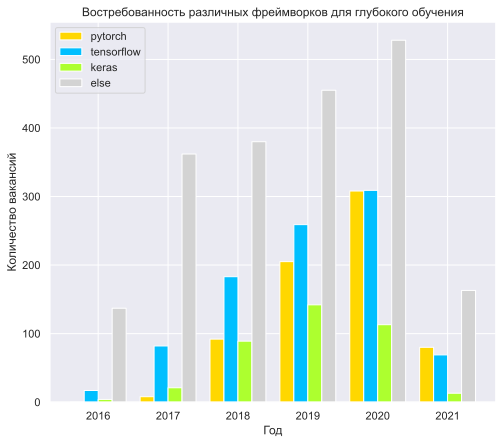

pytorch : {2016: 0, 2017: 8, 2018: 92, 2019: 205, 2020: 308, 2021: 80}
tensorflow : {2016: 17, 2017: 82, 2018: 183, 2019: 259, 2020: 309, 2021: 69}
keras : {2016: 4, 2017: 21, 2018: 89, 2019: 142, 2020: 113, 2021: 13}
else : {2016: 137, 2017: 362, 2018: 380, 2019: 455, 2020: 528, 2021: 163}


In [76]:
features = ['pytorch', 'tensorflow', 'keras']
distribution = get_distribution_by_years(messages[(messages.is_job == 1) & (messages.ts < '2021-03-01')], features, years)
build_hist_from_distribution(distribution, years,
                             title='Востребованность различных фреймворков для глубокого обучения',
                             xlabel='Год',
                             ylabel='Количество вакансий')
print_dict(distribution)

### Анализ уровней вакансий

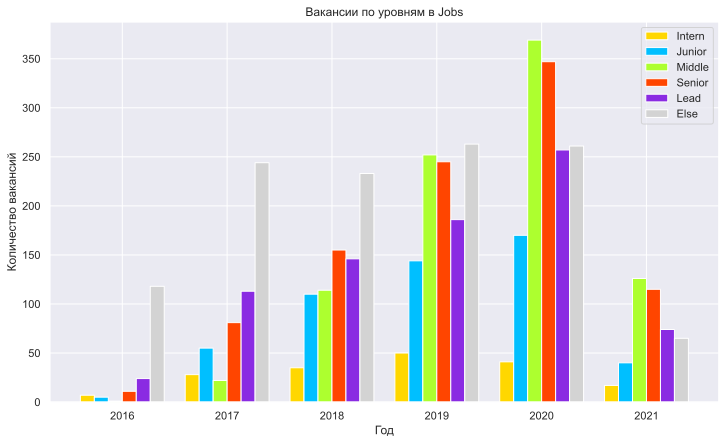

Intern : {2016: 7, 2017: 28, 2018: 35, 2019: 50, 2020: 41, 2021: 17}
Junior : {2016: 5, 2017: 55, 2018: 110, 2019: 144, 2020: 170, 2021: 40}
Middle : {2016: 1, 2017: 22, 2018: 114, 2019: 252, 2020: 369, 2021: 126}
Senior : {2016: 11, 2017: 81, 2018: 155, 2019: 245, 2020: 347, 2021: 115}
Lead : {2016: 24, 2017: 113, 2018: 146, 2019: 186, 2020: 257, 2021: 74}
Else : {2016: 118, 2017: 244, 2018: 233, 2019: 263, 2020: 261, 2021: 65}


In [36]:
years = range(2016, 2022)

dictionary_mapping = {
    'Intern': ['intern', 'стажер', 'стажёр'],
    'Junior': ['junior', 'джун', 'начинающ'],
    'Middle': ['middle', 'мидл', 'миддл'],
    'Senior': ['senior', 'синьор', 'сеньор', 'старш'],
    'Lead': ['lead', 'head', 'лид', 'ведущ']
}

distribution = get_technologies_distribution_and_years(messages[(messages.is_job == 1) & (messages.ts < '2021-03-01')],
                                                       dictionary_mapping, years)

build_hist_from_distribution(distribution, years,
                             title='Вакансии по уровням в Jobs',
                             xlabel='Год',
                             ylabel='Количество вакансий')
print_dict(distribution)

### Анализ типов вакансий

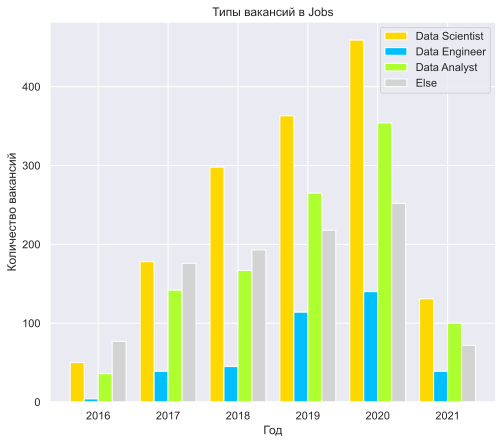

Data Scientist : {2016: 50, 2017: 178, 2018: 298, 2019: 363, 2020: 459, 2021: 131}
Data Engineer : {2016: 4, 2017: 39, 2018: 45, 2019: 114, 2020: 140, 2021: 39}
Data Analyst : {2016: 36, 2017: 142, 2018: 167, 2019: 265, 2020: 354, 2021: 100}
Else : {2016: 77, 2017: 176, 2018: 193, 2019: 218, 2020: 252, 2021: 72}


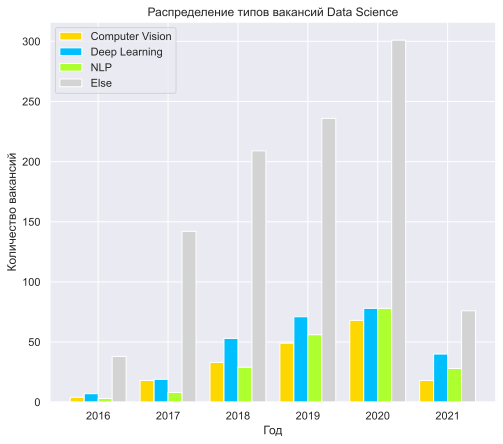

Computer Vision : {2016: 4, 2017: 18, 2018: 33, 2019: 49, 2020: 68, 2021: 18}
Deep Learning : {2016: 7, 2017: 19, 2018: 53, 2019: 71, 2020: 78, 2021: 40}
NLP : {2016: 3, 2017: 8, 2018: 29, 2019: 56, 2020: 78, 2021: 28}
Else : {2016: 38, 2017: 142, 2018: 209, 2019: 236, 2020: 301, 2021: 76}


In [37]:
years = range(2016, 2022)

dictionary_mapping = {
    'Data Scientist': [' ds ', 'data science', 'data scientist', 'дата саенс', 'дата саентист'],
    'Data Engineer': [' de ', 'data engineer', 'дата инженер'],
    'Data Analyst': [' da ', 'data analyst', 'data analytic', 'аналитик']
}

ds_jobs_mapping = {
    'Computer Vision': [' cv ', 'computer vision', 'компьютерное зрение', 'компьютерным зрением'],
    'Deep Learning': [' dl ', 'deep learning', 'глубокое обучение', 'глубоким обучением', 'глубокого обучения'],
    'NLP': [' nlp ', 'natural language processing', 'обработка естественного языка', 'обработкой естественного языка']
} 

distribution, ds_distribution = get_technologies_distribution_and_years(messages[(messages.is_job == 1) & (messages.ts < '2021-03-01')],
                                                       dictionary_mapping, years, ds_jobs_mapping)

build_hist_from_distribution(distribution, years,
                             title='Типы вакансий в Jobs',
                             xlabel='Год',
                             ylabel='Количество вакансий')

print_dict(distribution)

build_hist_from_distribution(ds_distribution, years,
                             title='Распределение типов вакансий Data Science',
                             xlabel='Год',
                             ylabel='Количество вакансий')

print_dict(ds_distribution)

## Анализ эмоций к вакансиям

In [ ]:
from collections import defaultdict

In [ ]:
reactions_dict = defaultdict(lambda: 0)
df = messages[messages['is_job'] == 1]
for _, message in df.iterrows():
    reactions = message['reactions']
    if isinstance(reactions, list):
        for reaction in reactions:
            name = reaction['name']
            count = reaction['count']
            reactions_dict[name] += count
sorted_reactions_dict = {key: value for key, value in sorted(reactions_dict.items(), reverse=True, key=lambda item: item[1])}
for key, value in sorted_reactions_dict.items():
    print(key, ':', value)

# len(reactions)

reactions_dict = {
    'ramen': -1, # лапша
    '+1': 1,
    'fireball': 1,
    'ban': -1,
    'notbad': 1,
    'venhead': 1, # бабушкин
    'fork': 1, # вилка не указана
    'fire': 1,
    'galera': 1, # outsource-компании
    'widefork': 1,
    'moneys': 1,
    'no-junior': 1,
    'naebalovo': -1
}

In [ ]:
%ls

In [ ]:
%ls processed_data

In [ ]:
df = pd.read_csv('processed_data/salaries_parsed_2017_06_01.csv')

In [ ]:
df